<a href="https://colab.research.google.com/github/elangbijak4/multi-agent-AI/blob/main/Multi_Agent_Cerdas_Hypergraf_Blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Proof-of-Concept: Epistemic Blackboard Blockchain (EBB) for Multi-Agent System
# Save this file as poc_ebb.py and run in Google Colab or any Python 3.8+ environment.
# This script simulates a small set of agents that:
# - locally detect anomalies based on a threshold
# - propose updates (new threshold) to the shared Epistemic Blackboard (a simple blockchain)
# - other agents evaluate the proposal on local validation data and vote
# - if weighted votes exceed the consensus threshold, the proposal is written to the blockchain
# - all agents adopt the approved update
#
# The PoC focuses on clarity and explainability for reviewers rather than on production-ready security.

import hashlib, json, time, random
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
import numpy as np

random.seed(42)
np.random.seed(42)

# -------------------------- Blockchain (Epistemic Blackboard) --------------------------
@dataclass
class Block:
    index: int
    timestamp: float
    proposer: str
    proposal: Dict[str, Any]  # e.g., {'type':'threshold_update', 'value': 1.5}
    prev_hash: str
    hash: str = ""
    signature: Optional[str] = None  # placeholder

    def compute_hash(self):
        block_string = json.dumps({
            "index": self.index,
            "timestamp": self.timestamp,
            "proposer": self.proposer,
            "proposal": self.proposal,
            "prev_hash": self.prev_hash
        }, sort_keys=True).encode()
        return hashlib.sha256(block_string).hexdigest()

class SimpleBlockchain:
    def __init__(self):
        genesis = Block(index=0, timestamp=time.time(), proposer="genesis",
                        proposal={"type":"genesis"}, prev_hash="0")
        genesis.hash = genesis.compute_hash()
        self.chain: List[Block] = [genesis]

    def add_block(self, block: Block):
        block.hash = block.compute_hash()
        self.chain.append(block)

    def last_hash(self):
        return self.chain[-1].hash

    def __repr__(self):
        return f"SimpleBlockchain(len={len(self.chain)})"

# -------------------------- Agent Definition --------------------------
@dataclass
class Agent:
    id: str
    threshold: float  # local threshold for anomaly detection
    weight: float     # reputation/trust weight for voting
    data_mu: float    # local data distribution mean (to create heterogeneity)
    data_sigma: float # local data distribution stddev
    history: List[Dict[str,Any]] = field(default_factory=list)

    def sense(self, n=50):
        """Simulate local observations with ground-truth anomaly threshold hidden to agents."""
        samples = np.random.normal(self.data_mu, self.data_sigma, size=n)
        return samples

    def local_detect(self, samples):
        """Return detections as boolean array using local threshold."""
        return samples > self.threshold

    def evaluate_proposal(self, proposal, validation_samples, gt_anomaly_threshold):
        """
        Evaluate a proposal on local validation_samples.
        Proposal example: {'type':'threshold_update', 'value': x}
        Return boolean vote and an evaluation score (accuracy improvement)
        """
        if proposal.get("type") != "threshold_update":
            return False, 0.0
        new_thresh = proposal.get("value")
        # current accuracy
        gt_labels = validation_samples > gt_anomaly_threshold
        old_preds = validation_samples > self.threshold
        new_preds = validation_samples > new_thresh
        old_acc = (old_preds == gt_labels).mean()
        new_acc = (new_preds == gt_labels).mean()
        # Vote 'yes' if new threshold improves local accuracy (strict improvement)
        vote = new_acc >= old_acc  # allow tie -> accept non-worse proposals
        score = new_acc - old_acc
        return vote, score

    def apply_update(self, proposal):
        if proposal.get("type") == "threshold_update":
            self.threshold = proposal.get("value")
            self.history.append({"time": time.time(), "updated_threshold": self.threshold, "proposal": proposal})

# -------------------------- Simulation Environment --------------------------
GT_ANOMALY_THRESHOLD = 2.0  # ground truth: values > 2.0 are anomalies (unknown to agents)

class Environment:
    def __init__(self, agents: List[Agent], consensus_tau=0.6):
        self.agents = agents
        self.blockchain = SimpleBlockchain()
        self.consensus_tau = consensus_tau  # fraction of total weight required
        self.metrics = {"rounds": [], "accepted": 0, "rejected": 0}

    def propose_and_vote(self, proposer: Agent, proposal: Dict[str,Any], val_samples_per_agent=200):
        # Each agent evaluates proposal on local validation samples
        votes = []
        total_weight = sum(a.weight for a in self.agents)
        weighted_yes = 0.0
        details = []
        for a in self.agents:
            vs = a.sense(n=val_samples_per_agent)  # local validation samples
            vote, score = a.evaluate_proposal(proposal, vs, GT_ANOMALY_THRESHOLD)
            votes.append((a.id, vote, a.weight, score))
            if vote:
                weighted_yes += a.weight
            details.append({"agent": a.id, "vote": vote, "weight": a.weight, "score": score})
        # Decide
        if (weighted_yes / total_weight) >= self.consensus_tau:
            # Accept: write block and apply update
            new_block = Block(index=len(self.blockchain.chain),
                              timestamp=time.time(),
                              proposer=proposer.id,
                              proposal=proposal,
                              prev_hash=self.blockchain.last_hash(),
                              hash="")  # will be computed in add_block
            self.blockchain.add_block(new_block)
            for a in self.agents:
                a.apply_update(proposal)
            accepted = True
            self.metrics["accepted"] += 1
        else:
            accepted = False
            self.metrics["rejected"] += 1
        return accepted, details

# Optional: a simple runner when executed
if __name__ == '__main__':
    import numpy as np
    import random, time
    random.seed(42); np.random.seed(42)
    agents = [
        Agent(id="A1", threshold=2.5, weight=1.0, data_mu=0.5, data_sigma=1.0),
        Agent(id="A2", threshold=1.8, weight=1.0, data_mu=0.8, data_sigma=1.2),
        Agent(id="A3", threshold=2.2, weight=1.0, data_mu=1.0, data_sigma=0.9),
        Agent(id="A4", threshold=2.7, weight=0.8, data_mu=0.3, data_sigma=1.5),
    ]
    env = Environment(agents, consensus_tau=0.6)
    rounds = 8
    print("Starting simulation")
    for r in range(1, rounds+1):
        proposer = random.choice(env.agents)
        current = proposer.threshold
        delta = random.uniform(-0.6, 0.6)
        new_thresh = max(0.5, min(3.5, current + delta))
        proposal = {"type":"threshold_update", "value": round(new_thresh, 3)}
        accepted, details = env.propose_and_vote(proposer, proposal, val_samples_per_agent=300)
        pooled_samples = np.concatenate([a.sense(n=300) for a in env.agents])
        gt_labels = pooled_samples > GT_ANOMALY_THRESHOLD
        accs = []
        for a in env.agents:
            accs.append(((pooled_samples > a.threshold) == gt_labels).mean())
        avg_acc = np.mean(accs)
        print(f"Round {r}: proposer={proposer.id}, proposal={proposal['value']}, accepted={accepted}, avg_agent_acc={avg_acc:.4f}")
    print("Final blockchain length:", len(env.blockchain.chain))
    for b in env.blockchain.chain:
        print(f"  idx={b.index}, proposer={b.proposer}, proposal={b.proposal}, hash={b.hash[:8]}...")


Starting simulation
Round 1: proposer=A1, proposal=1.93, accepted=True, avg_agent_acc=0.9842
Round 2: proposer=A3, proposal=1.624, accepted=False, avg_agent_acc=0.9850
Round 3: proposer=A2, proposal=2.214, accepted=False, avg_agent_acc=0.9858
Round 4: proposer=A1, proposal=2.039, accepted=True, avg_agent_acc=0.9933
Round 5: proposer=A1, proposal=1.475, accepted=False, avg_agent_acc=0.9958
Round 6: proposer=A2, proposal=1.718, accepted=False, avg_agent_acc=0.9942
Round 7: proposer=A1, proposal=2.112, accepted=False, avg_agent_acc=0.9933
Round 8: proposer=A4, proposal=1.704, accepted=False, avg_agent_acc=0.9975
Final blockchain length: 3
  idx=0, proposer=genesis, proposal={'type': 'genesis'}, hash=710b9c64...
  idx=1, proposer=A1, proposal={'type': 'threshold_update', 'value': 1.93}, hash=c0b05cbc...
  idx=2, proposer=A1, proposal={'type': 'threshold_update', 'value': 2.039}, hash=79a00da6...


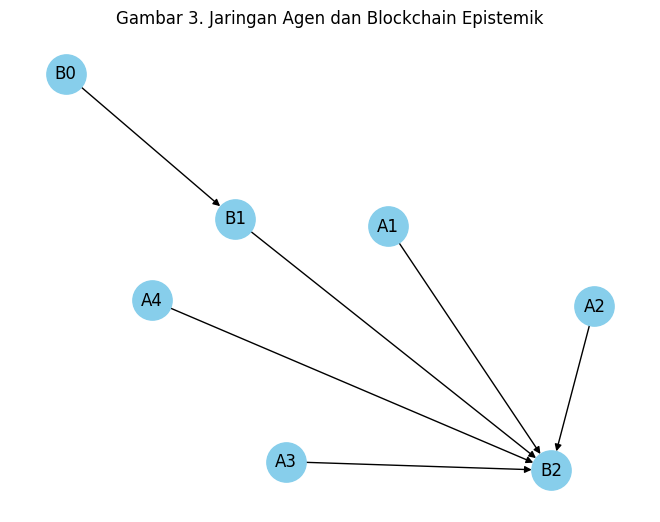

In [3]:
import networkx as nx, matplotlib.pyplot as plt
G = nx.DiGraph()
for a in env.agents:
    G.add_node(a.id, type="agent")
for b in env.blockchain.chain:
    G.add_node(f"B{b.index}", type="block")
for b in range(1, len(env.blockchain.chain)):
    G.add_edge(f"B{b-1}", f"B{b}")
for a in env.agents:
    G.add_edge(a.id, f"B{len(env.blockchain.chain)-1}")
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue')
plt.title("Gambar 3. Jaringan Agen dan Blockchain Epistemik")
plt.show()